In [1]:
import math
import json
import torch
import torch.nn as nn
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import base64
import io
import numpy as np
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from transformers import AutoTokenizer
import cv2
from tqdm.auto import tqdm
import torch.utils.checkpoint as checkpoint

torch.backends.cuda.enable_flash_sdp(True)
# set white background in matplotlib
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
with open('/projets/melodi/gsantoss/pages.json') as f:
    data = json.load(f)
    
    

def slice_image(img, size=16, stride=16):
    p_imag = img.unfold(0, size, stride).unfold(1, size, stride)
    return torch.flatten(p_imag, 0, end_dim=1)

tokenizer = AutoTokenizer.from_pretrained('google/byt5-small')

imgs = []
texts = []

for doc in tqdm(data):

    try:
        base64img = doc['image']
        img = base64.b64decode(base64img[22:])
        img = torch.from_numpy(np.array(Image.open(io.BytesIO(img))))

        # convert image to grayscale using cv2
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
        img = torch.from_numpy(img)

        imgs.append(torch.flatten(slice_image(img, size=16, stride=16), start_dim=1).unsqueeze(0))

        texts.append('<s>' + doc['text'])
    except:
        print(doc['image'])
        break
        pass
    
tokens = tokenizer(texts, return_tensors='pt', padding=True)
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
print(input_ids.shape, attention_mask.shape)
dataset = TensorDataset(torch.cat(imgs, dim=0).float(), input_ids, attention_mask)

  0%|          | 0/134 [00:00<?, ?it/s]

torch.Size([134, 6694]) torch.Size([134, 6694])


In [4]:


def shift(t):
    pad = torch.zeros(t.shape[0], t.shape[1], 1).to(t.device)
    t = torch.cat([pad, t], dim=-1)
    t = t.view(t.shape[0], t.shape[2], t.shape[1])

    return t[:, 1:, :]


def pos_encode(max_len, d_model):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class RelAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(RelAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.qw = nn.Linear(d_model, d_model)
        self.kw = nn.Linear(d_model, d_model)
        self.vw = nn.Linear(d_model, d_model)

        self.drop = nn.Dropout(dropout)

        self.cw = nn.Linear(d_model, d_model)

        self.scale = 1 / (d_model ** 0.5)

    def forward(self, x, u, v, pos, mem=None, mask=None):

        if mem is None:
            mememb = x
        else:
            mememb = torch.cat([mem, x], dim=1)

        qw = self._reshape_mh(self.qw(mememb))
        kw = self._reshape_mh(self.kw(mememb))
        vw = self._reshape_mh(self.vw(mememb))

        rsp = self._reshape_mh(pos)
        ac = torch.einsum('ijk,imk->ijm', (qw + u), kw)

        bd = torch.einsum('ijk,ilk->ijl', (qw + v), rsp)
        bd = shift(bd)
        att = ac + bd
        att.mul_(self.scale)
        if mask is not None:
            att = att.masked_fill(mask != 0, -1e4)

        att = torch.softmax(att, dim=-1)
        att = self.drop(att)

        out = att @ vw.float()

        return self.cw(self._reshape_out(out))

    def _reshape_mh(self, x):
        x = x.view(x.shape[0], x.shape[1], self.n_heads, -1)
        x = x.permute(0, 2, 1, 3)
        return x.reshape(x.shape[0] * x.shape[1], x.shape[2], -1)

    def _reshape_out(self, x):
        x = x.reshape(-1, self.n_heads, x.shape[1], x.shape[2])
        x = x.permute(0, 2, 1, 3)
        return x.reshape(x.shape[0], x.shape[1], -1)


class MHA(nn.Module):
    def __init__(self, d_model, num_heads, drop=0.1):
        super(MHA, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.qw = nn.Linear(d_model, d_model)
        self.kw = nn.Linear(d_model, d_model)
        self.vw = nn.Linear(d_model, d_model)

        self.drop = nn.Dropout(drop)

        self.cw = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        wq = self._reshape_mh(self.qw(q))
        wk = self._reshape_mh(self.kw(k))
        wv = self._reshape_mh(self.vw(v))

        aw = torch.bmm(wq, wk.transpose(-2, -1)) / math.sqrt(wq.shape[-1])

        if mask is not None:
            aw = aw.masked_fill(mask != 0, -1e4)
        a = torch.softmax(aw, dim=-1)
        a = self.drop(a)
        fw = a @ wv

        return self.cw(self._reshape_out(fw))

    def _reshape_mh(self, x):
        x = x.view(x.shape[0], x.shape[1], self.num_heads, -1)
        x = x.permute(0, 2, 1, 3)
        return x.reshape(x.shape[0] * x.shape[1], x.shape[2], -1)

    def _reshape_out(self, x):
        x = x.reshape(-1, self.num_heads, x.shape[1], x.shape[2])
        x = x.permute(0, 2, 1, 3)
        return x.reshape(x.shape[0], x.shape[1], -1)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff):
        super(EncoderLayer, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MHA(d_model, num_heads)
        self.mhad = nn.Dropout(0.1)

        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dff, d_model),
            nn.Dropout(0.1)
        )

    def forward(self, x, mask=None):
        nx = self.ln1(x)
        atv = self.mha(nx, nx, nx, mask)
        av = nx + self.mhad(atv)

        no = self.ln2(av)
        return no + self.ff(no)


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff):
        super(DecoderLayer, self).__init__()
        self.num_heads = num_heads
        self.ln1 = nn.LayerNorm(d_model)
        self.rmha = RelAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(0.1)

        self.ln2 = nn.LayerNorm(d_model)
        self.ca = MHA(d_model, num_heads)
        self.dropout2 = nn.Dropout(0.1)

        self.ln3 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dff, d_model),
            nn.Dropout(0.1)
        )

    def forward(self, x, y, u, v, pos, mem=None, mask1=None, mask2=None):
        nx = self.ln1(x)
        rl = self.dropout1(self.rmha(nx, u, v, pos, mem=mem, mask=mask1))
        av = nx + rl[:, -x.shape[1]:, :]
        no = self.ln2(av)
        atv = self.ca(no, y, y, mask2)
        fv = no + self.dropout2(atv)

        lv = self.ln3(fv)
        return lv + self.ff(lv)


class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, dff, num_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, dff) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        out = x
        for layer in self.layers:
            out = layer(out, mask)

        return out


def rel_pos(pos_seq, demb):
    inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))

    sinusoid_inp = torch.ger(pos_seq, inv_freq)
    return torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)


class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, dff, num_layers):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, dff) for _ in range(num_layers)])
        self.u = nn.Parameter(torch.rand((1, 1, d_model // num_heads)))
        self.v = nn.Parameter(torch.rand((1, 1, d_model // num_heads)))

    def forward(self, x, y, mem=None, mask1=None, mask2=None):
        out = x
        new_mem = []
        ml = mem[0].shape[1] if mem is not None else 0
        pos_seq = torch.arange(x.shape[1] + ml - 1, -1, -1.0)
        pos = rel_pos(pos_seq, self.d_model).to(x.device).unsqueeze(0).repeat(x.shape[0], 1, 1)
        for i, layer in enumerate(self.layers):
            out = layer(out, y, self.u, self.v, pos, mem=mem[i] if mem is not None else None, mask1=mask1, mask2=mask2)
            new_mem.append(out.detach())
        return out, new_mem


class VitXl(nn.Module):
    def __init__(self, vocab_size, vsize, d_model, num_heads, dff, num_layers, max_len=512, seq_len=1024, mem_len=512):
        super(VitXl, self).__init__()

        self.seq_len = seq_len
        self.mem_len = mem_len
        self.num_heads = num_heads

        self.v_encoder = nn.Sequential(
            nn.Linear(vsize, dff),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dff, d_model),
            nn.Dropout(0.1)
        )

        self.pos = nn.Parameter(pos_encode(max_len, d_model), requires_grad=False)
        self.encoder = Encoder(d_model, num_heads, dff, num_layers)

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.decoder = Decoder(d_model, num_heads, dff, num_layers)

    def forward(self, x, y):
        x = self.v_encoder(x)
        x += self.pos[:x.shape[1], :].to(x.device)
        vx = self.encoder(x)

        ey = self.embedding(y)
        final_out = []
        mem = None
        for chunk in torch.split(ey, self.seq_len, dim=1):
            ml = mem[0].shape[1] if mem is not None else 0
            sl = chunk.shape[1] + ml
            m1 = torch.triu(torch.ones((1, sl, sl)), diagonal=1).to(chunk.device)
            m2 = torch.triu(torch.ones((1, chunk.shape[1], vx.shape[1])), diagonal=1).to(chunk.device)
            out, nm = checkpoint.checkpoint(self.decoder, chunk, vx, mem, m1, m2)
            mem = [mv[:, -self.mem_len:, :] for mv in nm]
            final_out.append(out)

        return vx, torch.cat(final_out, dim=1)



# 
# vit = VitXl(tokenizer.vocab_size, 256, 384, 6, 1024, 4, max_len=800, seq_len=512, mem_len=64)
# vit.cuda(0)
# e1 = torch.rand((32, 800, 256))
# e2 = torch.randint(0, 3, (32, 6000))
# 
# with torch.cuda.amp.autocast():
#     vx, ey = vit(e1.cuda(0), e2.cuda(0))
# print(vx.shape, ey.shape)

In [8]:
class PretrainVit(nn.Module):
    def __init__(self, vit, vocab_size, v_dim=256, n_dim=512, dim_feedforward=1024):
        super(PretrainVit, self).__init__()

        self.vit = vit
        self.vd = nn.Sequential(
            nn.Linear(n_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim_feedforward, v_dim),
            nn.Sigmoid()
        )
        self.td = nn.Sequential(
            nn.Linear(n_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim_feedforward, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, y):
        vx, vy = self.vit(x, y)
        return self.vd(vx), self.td(vy)




100%|██████████| 250/250 [18:49<00:00,  4.52s/it]


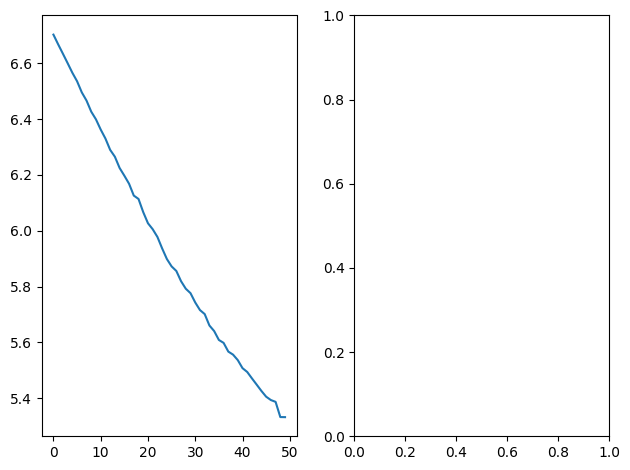

loss: 5.33


In [9]:
vit = VitXl(tokenizer.vocab_size, 256, 384, 6, 1024, 4, max_len=800, seq_len=512, mem_len=64)
pretrain = PretrainVit(vit, tokenizer.vocab_size, v_dim=256, n_dim=384)



# checkpoint = torch.load('/projets/melodi/gsantoss/models/checkpoint_pdfre.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
pretrain = nn.DataParallel(pretrain)
pretrain.cuda(0)
pretrain.train()
crit1 = nn.BCELoss()
crit2 = nn.NLLLoss(reduction='none')

optimizer = optim.Adam(pretrain.parameters(), lr=0.000003)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
batch_size = 32
epochs = 50
progress = tqdm(total=epochs * math.ceil(len(dataset) / batch_size))
lh = []
epoch = 0


compiled = torch.compile(pretrain)

# lh = checkpoint['loss']
# epoch = checkpoint['epoch']

progress.update(epoch * math.ceil(len(dataset) / batch_size))

for epoch in range(epoch, epochs):
    el = []
    for x, y, ya in DataLoader(dataset, batch_size=batch_size, shuffle=True):
        optimizer.zero_grad()
        
        with torch.no_grad():
            vn = torch.randn_like(x).cuda(0)
            tn = torch.randint_like(y, 0, tokenizer.vocab_size).cuda(0)
    
            vnm = torch.rand(x.shape[0], x.shape[1]) < 0.15
            tnm = torch.rand(y.shape[0], y.shape[1]) < 0.15
    
            vn *= vnm.unsqueeze(-1).float().cuda(0)
            tn *= tnm.long().cuda(0)
    
            x = torch.clamp(x.cuda(0) + vn, 0, 1)
            y = torch.clamp(y.cuda(0) + tn, 0, tokenizer.vocab_size - 1)
    
            vn = torch.rand(x.shape[0], x.shape[1]) > 0.85
    
            x *= vn.unsqueeze(-1).float().cuda(0)
        
        with torch.cuda.amp.autocast():
            r1, r2 = compiled(x.cuda(0), y.long().cuda(0))

        l1 = crit1(r1.float().cpu(), x.cpu())

        rf = torch.flatten(r2[:, :-1, :].float().cpu(), start_dim=0, end_dim=1)
        yf = torch.flatten(y[:, 1:], start_dim=0, end_dim=1).cpu()
        l2 = crit2(rf, yf) * (yf != 0).float()
        l2 = l2.sum() / (yf != 0).float().sum()
    
        loss = l1 + l2

        loss.backward()
        el.append(loss.item())
        optimizer.step()
        progress.update(1)

    lh.append(sum(el) / len(el))


progress.close()
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(lh)
plt.show()


torch.save({
            'epoch': epoch,
            'model_state_dict': pretrain.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lh,
            }, '/projets/melodi/gsantoss/models/checkpoint_pdfre.pt')

torch.save(pretrain.module.vit.state_dict(), '/projets/melodi/gsantoss/models/pdfre.pt' )
print(f'loss: {lh[-1]:0.2f}')

In [5]:
class PDFReader(nn.Module):
    def __init__(self, encoder, vocab_size, d_model=768, dim_feedforward=2048):
        super(PDFReader, self).__init__()
        self.encoder = encoder

        self.ll = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim_feedforward, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, y):
        vx, vy = self.encoder(x, y)

        return self.ll(vy)

  0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


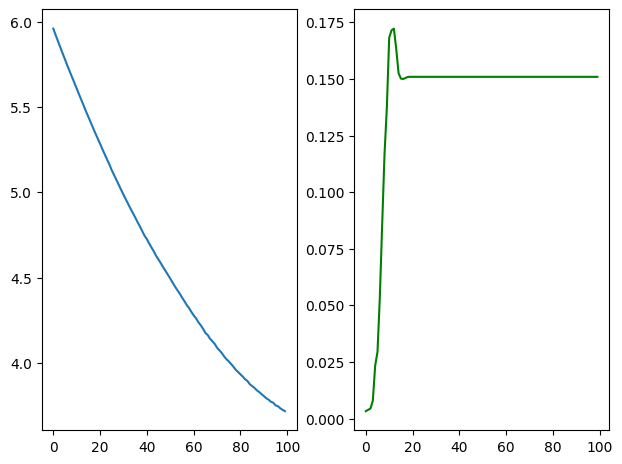

loss: 3.72, acc: 0.15


In [6]:
def model_eval(model, data, batch_size=32):
    pred = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, ym, ya in DataLoader(data, batch_size=batch_size):
            res = model(x.cuda(0), ym.cuda(0)).exp().argmax(dim=-1).cpu()
            comp = res[:, :-1] == ym[:, 1:]
            pred += torch.sum(comp.float() * (ym[:, 1:] != 0).float())
            total += torch.sum((ym[:, 1:] != 0).float())

    model.train()
    return pred / total


vit = VitXl(tokenizer.vocab_size, 256, 384, 6, 1024, 4, max_len=800, seq_len=512, mem_len=64)
# vit.load_state_dict(torch.load('/projets/melodi/gsantoss/models/pdfre.pt'))

model = PDFReader(vit, tokenizer.vocab_size, d_model=384, dim_feedforward=1024)

model = nn.DataParallel(model)
model.cuda(0)

crit = nn.NLLLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.000003)
batch_size = 32
epochs = 100
lh = []
th = []
test = TensorDataset(*dataset[:10])
train = TensorDataset(*dataset[10:])
progress = tqdm(total=epochs * math.ceil(len(train) / batch_size))

compiled = torch.compile(model)

for e in range(epochs):
    el = []
    for x, y, ya in DataLoader(train, batch_size=batch_size, shuffle=True):
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            res = compiled(x.cuda(0), y.long().cuda(0))
        rf = torch.flatten(res[:, :-1, :], start_dim=0, end_dim=1)
        yf = torch.flatten(y[:, 1:], start_dim=0, end_dim=1).cuda(0)
        loss = crit(rf, yf) * (yf != 0).float()
        loss = loss.sum() / (yf != 0).float().sum()
        loss.backward()
        el.append(loss.item())
        optimizer.step()
        progress.update(1)

    lh.append(sum(el) / len(el))
    th.append(model_eval(compiled, test))


progress.close()
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(lh)
ax[1].plot(th, c='g')
plt.show()

torch.save(model.module.state_dict(), '/projets/melodi/gsantoss/models/pdfr.pt' )
print(f'loss: {lh[-1]:0.2f}, acc: {th[-1]:0.2f}')